# yFiles

This example demonstrates how the NetworkX-Graph created by PT3S can be used with yFiles.

# PT3S Release

In [1]:
#pip install PT3S -U --no-deps

# Imports

In [2]:
import os
import geopandas
from geopandas import GeoSeries
import logging
import pandas as pd
import io

import subprocess

import matplotlib.pyplot as plt

import matplotlib
import matplotlib.colors as mcolors

import folium
from folium.plugins import HeatMap

import networkx as nx

import typing
from yfiles_jupyter_graphs import GraphWidget

try:
    from PT3S import dxAndMxHelperFcts
except:
    import dxAndMxHelperFcts
    
try:
    from PT3S import Mx
except:
    import Mx

try:
    from PT3S import Rm
except:
    import Rm

In [3]:
import importlib

# Logging

In [4]:
logger = logging.getLogger()  

logFileName= r"Example6.log" 

loglevel = logging.DEBUG
logging.basicConfig(filename=logFileName
                        ,filemode='w'
                        ,level=loglevel
                        ,format="%(asctime)s ; %(name)-60s ; %(levelname)-7s ; %(message)s")    

fileHandler = logging.FileHandler(logFileName)     

logger.addHandler(fileHandler)

consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logging.Formatter("%(levelname)-7s ; %(message)s"))
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)

# Read Model and Results

In [5]:
dbFilename="Example6"
dbFile=os.path.join(os.path.dirname(os.path.abspath(dxAndMxHelperFcts.__file__))
                    +'/Examples/'
                    +dbFilename
                    +'.db3'
)

In [6]:
m=dxAndMxHelperFcts.readDxAndMx(dbFile=dbFile,preventPklDump=True,maxRecords=0)
#NBVAL_IGNORE_OUTPUT

INFO    ; Dx.__init__: dbFile (abspath): c:\users\aUserName\3s\pt3s\Examples\Example6.db3 exists readable ...


# Network Graph m.G

## GNet: only the Net, only the Supply layer

In [7]:
netNodes=[n for (n,data) in m.G.nodes(data=True) if 
    data['KVR'] in [1,'1'] # nur der VL
and data['ID_CONT']==data['IDPARENT_CONT'] # nur das Netz
]

In [8]:
GNet=m.G.subgraph(netNodes)

## examine GNet with nx

In [9]:
nx.number_connected_components(GNet)

1

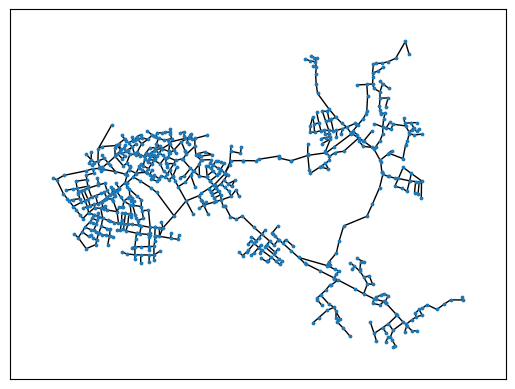

In [10]:
nx.draw_networkx(GNet,with_labels = False,node_size=3,pos=m.nodeposDctNx)

## examine max. disconnected Subgraph

Separating valves are defined in the network.
If necessary, separating valves can divide the network into individual areas, e.g. for isolating areas with large leaks.
All separating valves are defined in the model as follows: They are located in the “TS” block.

In [11]:
def falseIfSeparatingValveTrueElse(n1, n2):
    if GNet[n1][n2]['NAME_CONT']=='TS' and GNet[n1][n2]['OBJTYPE']=='VENT':
        return False
    else:
        return True

In [12]:
Ghk=nx.subgraph_view(GNet,filter_edge=falseIfSeparatingValveTrueElse)

In [13]:
nx.number_connected_components(Ghk)

25

## examine Subgraph in terms of raw data

In [14]:
gNetNodeTks=[data['tk'] for n, data in GNet.nodes(data=True)]

In [15]:
dfNodes=m.V3_KNOT
dfNodes=dfNodes[(dfNodes['tk'].isin(gNetNodeTks))]
dfNodes.shape[0],len(GNet.nodes)

(773, 773)

In [16]:
dfEdges=m.V3_VBEL.reset_index()
dfEdges=dfEdges[(dfEdges['fkKI'].isin(gNetNodeTks))  &
             (dfEdges['fkKK'].isin(gNetNodeTks))
]
dfEdges.shape[0],len(GNet.edges)

(891, 891)

# Subgraph as yFiles

In [17]:
w=GraphWidget(graph=GNet)

## set node grouping

### construct group nodes (not used)

In [18]:
pzon_nodes = [
    {"id": int(pzon)
    , "properties": {"label": pzon
    , 'NAME_PZON': pzon
    ,'NAME_CONT_VKNO': None
    ,'NAME': pzon
    }
    , "coordinates": [m.gdf_KNOT[m.gdf_KNOT['NAME_PZON']==pzon].to_crs('EPSG:4326').dissolve().centroid.geometry.iloc[0].centroid.y
                     ,m.gdf_KNOT[m.gdf_KNOT['NAME_PZON']==pzon].to_crs('EPSG:4326').dissolve().centroid.geometry.iloc[0].centroid.x]
    }
    for pzon in sorted(dfNodes['NAME_PZON'].unique())
]

### let yFiles contruct the group nodes

yFiles requests for grouping so called group nodes; if w.node_parent_group_mapping is used instead of w.node_parent_mapping yFiles constructs group nodes implicitely

In [19]:
w.get_node_parent_group_mapping() 

<function yfiles_jupyter_graphs.widget.GraphWidget.default_node_parent_group_mapping(index: int, node: Dict)>

In [20]:
def my_node_coordinates(node: typing.Dict):
    
    
   
    geom=GeoSeries.from_wkb([node['properties']['GEOMWKB']],crs='EPSG:25832').to_crs('EPSG:4326').geometry.iloc[0]
    lon=geom.centroid.x 
    lat=geom.centroid.y   
    return(lat,lon)
    

In [21]:
my_node_coordinates(w.nodes[0])

(0.8786146522356224, 4.934136819079871)

In [22]:
def my_node_parent_group_mapping(node: typing.Dict):
    
    return {
        'label':node['properties']['NAME_PZON']
        ,"coordinates": [my_node_coordinates(node)[0],my_node_coordinates(node)[1]]
        
        
       # [m.gdf_KNOT[m.gdf_KNOT['NAME_PZON']==node['properties']['NAME_PZON']].to_crs('EPSG:4326').dissolve().centroid.geometry.iloc[0].centroid.y
        #             ,m.gdf_KNOT[m.gdf_KNOT['NAME_PZON']==node['properties']['NAME_PZON']].to_crs('EPSG:4326').dissolve().centroid.geometry.iloc[0].centroid.x]
        
        
        
        #[my_node_coordinates(node)[0],my_node_coordinates(node)[1]]
    }
   

In [23]:
my_node_parent_group_mapping(w.nodes[0])

{'label': '13', 'coordinates': [0.8786146522356224, 4.934136819079871]}

In [24]:
w.set_node_parent_group_mapping(my_node_parent_group_mapping) 

In [25]:
#w.node_parent_group_mapping = "NAME_PZON"

## set node coordinate mapping

In [26]:
w.get_node_coordinate_mapping()

<function yfiles_jupyter_graphs.widget.GraphWidget.default_node_coordinate_mapping(index: int, node: Dict)>

In [27]:
def my_node_coordinate_mapping(node: typing.Dict):

    if 'GEOMWKB' in node['properties'].keys():
        
        #geom=GeoSeries.from_wkb([node['properties']['GEOMWKB']],crs='EPSG:25832').to_crs('EPSG:4326').geometry.iloc[0]
        #lon=geom.centroid.x 
        #lat=geom.centroid.y   
        #return(lat,lon)
        
        return my_node_coordinates(node)
        
    elif "coordinates" in node.keys():
        return node['coordinates']
    
    elif "coordinates" in node['properties'].keys():
        return (node['properties']['coordinates'][0],node['properties']['coordinates'][1])
    
    else:
        print('ERROR in my_node_coordinate_mapping.')
        #return(0,0)
        
        

In [28]:
node=w.nodes[0]
#sorted(node['properties'])#['GEOMWKB']

In [29]:
my_node_coordinate_mapping(node)

(0.8786146522356224, 4.934136819079871)

In [30]:
w.set_node_coordinate_mapping(my_node_coordinate_mapping)

## set edge thickness mapping

In [31]:
w.get_edge_thickness_factor_mapping()

<function yfiles_jupyter_graphs.widget.GraphWidget.default_edge_thickness_factor_mapping(index: int, edge: Dict)>

In [32]:

DImin=dfEdges['DI'].min()
DImax=dfEdges['DI'].max()
norm = plt.Normalize(vmin=DImin, vmax=DImax)

line_width_factor=10
line_width_min=1

def my_edge_thickness_factor_mapping(edge: typing.Dict):
    """DI as thickness"""
    if edge['properties']['OBJTYPE']=='VENT':
        return max(line_width_min,norm(DImax)*line_width_factor) # VENTs (Valves) with max. ROHR-(Pipe-)Thickness
    else:        
        if 'DI' in edge['properties'].keys():
            if isinstance(edge['properties']['DI'],float):
                return max(line_width_min,norm(edge['properties']['DI'])*line_width_factor)
        else:
            return line_width_min

In [33]:
edge=w.edges[0]
#sorted(edge['properties'])

In [34]:
my_edge_thickness_factor_mapping(edge)

1

In [35]:
w.set_edge_thickness_factor_mapping(my_edge_thickness_factor_mapping)

## set edge color mapping

In [36]:
w.get_edge_color_mapping()

<bound method GraphWidget.default_edge_color_mapping of GraphWidget(layout=Layout(height='500px', width='100%'))>

In [37]:
colors=['lightgrey', 'dimgrey']
cmap = mcolors.LinearSegmentedColormap.from_list('cmap', colors, N=256)

cMin=matplotlib.colors.to_rgb(cmap(norm(DImin)))

def my_edge_color_mapping(edge: typing.Dict):
    """DI as color"""
    if edge['properties']['OBJTYPE']=='VENT':
        return matplotlib.colors.to_hex('red')#"#0096C7" #matplotlib.colors.to_rgb('red') .to_hex(c
    else:
        if 'DI' in edge['properties'].keys():
            if isinstance(edge['properties']['DI'],float):
                return matplotlib.colors.to_hex(cmap(norm(edge['properties']['DI'])))
        else:            
            return cMin

In [38]:
my_edge_color_mapping(edge)

'#cdcdcd'

In [39]:
matplotlib.colors.to_rgb('red')

(1.0, 0.0, 0.0)

In [40]:
cMin

(0.8274509803921568, 0.8274509803921568, 0.8274509803921568)

In [41]:
w.set_edge_color_mapping(my_edge_color_mapping)

## set node size mapping

In [42]:
w.get_node_size_mapping()

<function yfiles_jupyter_graphs.widget.GraphWidget.default_node_size_mapping(index: int, node: Dict)>

In [43]:
def my_node_size_mapping(node: typing.Dict):
    """Select a width and height for the node"""
    
    width_default=55
    height_default=55
    
    if 'NAME_CONT_VKNO' not in node['properties'].keys(): # yFiles' implicit created nodes ...
        return width_default/10.,height_default/10.
    
    if not pd.isnull(node['properties']['NAME_CONT_VKNO']):
        if node['properties']['NAME_CONT_VKNO'] in ['H','R']:
            return  width_default*2,height_default*2
        else:
            return  width_default,height_default
    else:
        return width_default/10.,height_default/10.

In [44]:
#sorted(node['properties'])

In [45]:
w.set_node_size_mapping(my_node_size_mapping)

## set node label mapping

In [46]:
w.get_node_label_mapping()

<bound method GraphWidget.default_node_label_mapping of GraphWidget(layout=Layout(height='500px', width='100%'))>

In [47]:
def my_node_label_mapping(node: typing.Dict):
    """"""
    if 'NAME' in node['properties'].keys(): # yFiles' implicit created nodes ...
        dct= {'text':node['properties']['NAME']}
    elif 'label' in node['properties'].keys():
        dct= {'text':node['properties']['label']}
    
    if 'NAME_CONT_VKNO' not in node['properties'].keys(): # yFiles' implicit created nodes ...
        return dct
    
    if not pd.isnull(node['properties']['NAME_CONT_VKNO']):
        if node['properties']['NAME_CONT_VKNO'] in (['H','R']):
            pass
            #dct['backgroundColor']=matplotlib.colors.to_hex('red')
          
    
    return dct

In [48]:
w.set_node_label_mapping(my_node_label_mapping)

## set node style mapping

In [49]:
w.get_node_styles_mapping()

<function yfiles_jupyter_graphs.widget.GraphWidget.default_node_styles_mapping(index: int, node: Dict)>

In [50]:
def my_node_styles_mapping(node: typing.Dict):
    """"""
    if 'NAME' in node['properties'].keys(): # yFiles' implicit created nodes ...
        dct= {}
    elif 'label' in node['properties'].keys():
        dct= {}
    
    if 'NAME_CONT_VKNO' not in node['properties'].keys(): # yFiles' implicit created nodes ...
        return {}
    
    if not pd.isnull(node['properties']['NAME_CONT_VKNO']):
        if node['properties']['NAME_CONT_VKNO'] in (['H','R']):
            pass
            dct['color']=matplotlib.colors.to_hex('blue')
            if node['properties']['NAME_CONT_VKNO']=='R':
                dct['shape']='octagon'
            elif node['properties']['NAME_CONT_VKNO']=='H':
                dct['shape']='hexagon'
          
    
    return dct

In [51]:
w.set_node_styles_mapping(my_node_styles_mapping)

In [52]:
#dir(node)

## show graph

In [53]:
display(w)

GraphWidget(layout=Layout(height='800px', width='100%'))

# corresponding Graph with groups as nodes

In [54]:
zone_nodes = [
    {"id": int(pzon)
    , "properties": {"label": pzon
    , 'NAME_PZON': pzon
   # ,'NAME_CONT_VKNO': None
   # ,'NAME': pzon
    }
    , "coordinates": [m.gdf_KNOT[m.gdf_KNOT['NAME_PZON']==pzon].to_crs('EPSG:4326').dissolve().centroid.geometry.iloc[0].centroid.y
                     ,m.gdf_KNOT[m.gdf_KNOT['NAME_PZON']==pzon].to_crs('EPSG:4326').dissolve().centroid.geometry.iloc[0].centroid.x]
    }
    for pzon in sorted(dfNodes['NAME_PZON'].unique())
]

In [55]:
#pzon_nodes

In [56]:
df_zone_edges=dfEdges[(dfEdges['OBJTYPE'].isin(['VENT']))          
           &
             (dfEdges['ID_CONT']!=dfEdges['IDPARENT_CONT'])
]

In [57]:
zone_edges = [
    {"start": dfNodes[dfNodes['NAME']==row['NAME_i']].iloc[0]['NAME_PZON'] 
    , "end": dfNodes[dfNodes['NAME']==row['NAME_k']].iloc[0]['NAME_PZON'] 
    , "label": ""
    , "properties": {}
    , "directed": False}
    for index, row in df_zone_edges.iterrows()
]

In [58]:
wz = GraphWidget()

In [59]:
wz.edges = zone_edges
wz.nodes = zone_nodes 

In [60]:
wz.set_node_coordinate_mapping="coordinates"

In [61]:
display(wz)

GraphWidget(layout=Layout(height='750px', width='100%'))